In [23]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import math

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

metop = 'MetOP_A'

In [24]:
ds= xr.open_dataset(f"/srv/data2/srai_poseidon/srai_poseidon/observation/SatelliteVsBuoy/downloads/Buoy/TAO_data/WINDS/{metop}/T_000N_165E_COARE3p5_2013_2020_2hrMeanVar_AS_Buoy_Glorys_Wave_Matchup.nc")
ds

<xarray.Dataset> Size: 1MB
Dimensions:            (AS_TIME: 1639, NUMCELLS: 3, HEIGHT: 3, DEPTH: 1)
Coordinates:
  * AS_TIME            (AS_TIME) datetime64[ns] 13kB 2007-08-18T22:46:19 ... ...
  * NUMCELLS           (NUMCELLS) int64 24B 0 1 2
  * HEIGHT             (HEIGHT) float32 12B 3.0 4.0 10.0
  * DEPTH              (DEPTH) float32 4B 1.0
Data variables: (12/83)
    wvc_index          (AS_TIME, NUMCELLS) float64 39kB ...
    model_speed        (AS_TIME, NUMCELLS) float64 39kB ...
    model_dir          (AS_TIME, NUMCELLS) float64 39kB ...
    ice_prob           (AS_TIME, NUMCELLS) float64 39kB ...
    ice_age            (AS_TIME, NUMCELLS) float64 39kB ...
    wvc_quality_flag   (AS_TIME, NUMCELLS) float64 39kB ...
    ...                 ...
    vo                 (AS_TIME) float64 13kB ...
    zos                (AS_TIME) float64 13kB ...
    uo                 (AS_TIME) float64 13kB ...
    thetao             (AS_TIME) float64 13kB ...
    so                 (AS_TIME) float64 13kB ...
    GLORYS_TIME        (AS_TIME) datetime64[ns] 13kB ...

In [25]:
flag_dict = {
    f'{meaning:41s}': bin(mask)[2:].zfill(23)
    for meaning, mask in zip(ds.wvc_quality_flag.flag_meanings.split(), ds.wvc_quality_flag.flag_masks)
}
flag_dict

{'distance_to_gmf_too_large                ': '00000000000000001000000',
 'data_are_redundant                       ': '00000000000000010000000',
 'no_meteorological_background_used        ': '00000000000000100000000',
 'rain_detected                            ': '00000000000001000000000',
 'rain_flag_not_usable                     ': '00000000000010000000000',
 'small_wind_less_than_or_equal_to_3_m_s   ': '00000000000100000000000',
 'large_wind_greater_than_30_m_s           ': '00000000001000000000000',
 'wind_inversion_not_successful            ': '00000000010000000000000',
 'some_portion_of_wvc_is_over_ice          ': '00000000100000000000000',
 'some_portion_of_wvc_is_over_land         ': '00000001000000000000000',
 'variational_quality_control_fails        ': '00000010000000000000000',
 'knmi_quality_control_fails               ': '00000100000000000000000',
 'product_monitoring_event_flag            ': '00001000000000000000000',
 'product_monitoring_not_used              ': '0001

In [26]:
def getSubDF(ds, LAT, LON):
    subds = xr.Dataset()

    taoTimeVar = ['TAO_TIME']
    
    windVars = ['WDIR',
         'WDIR_QC',
         'WDIR_DM',
         'WSPD',
         'WSPD_QC',
         'WSPD_DM',
         'UWND',
         'VWND']

    sstVars = ['SST',
             'SST_QC',
             'SST_DM']
    
    airtVars = ['AIRT',
             'AIRT_QC',
             'AIRT_DM']
    
    rhVars = ['RELH',
             'RELH_QC',
             'RELH_DM']
    
    u10Vars =['WSPD_10N',
             'WSPD_10']

    statVars= [f'mean_WSPD',
               f'std_WSPD',
               f'mean_WSPD_10N',
               f'std_WSPD_10N',
               f'mean_U10N_x',
               f'std_U10N_x',
               f'mean_U10N_y',
               f'std_U10N_y',
               f'mean_WDIR',
               f'std_WDIR',
               f'mean_cosWDIR',
               f'std_cosWDIR',
               f'mean_sinWDIR',
               f'std_sinWDIR',
               f'mean_SST',
               f'std_SST',
               f'mean_AIRT',
               f'std_AIRT',
               f'mean_SST - AIRT',
               f'std_SST - AIRT',
               f'mean_RELH',
               f'std_RELH',]
    
    
    satVars = ['wind_speed',
             'wind_dir',
             'wvc_quality_flag',
             'model_speed',
             'model_dir',
             'bs_distance',
             'dist_from_TAO_pos']

    waveVars = ['VHM0',
                 'VHM0_SW1',
                 'VHM0_SW2',
                 'VHM0_WW',
                 'VMDR',
                 'VMDR_SW1',
                 'VMDR_SW2',
                 'VMDR_WW',
                 'VPED',
                 'VSDX',
                 'VSDY',
                 'VTM01_SW1',
                 'VTM01_SW2',
                 'VTM01_WW',
                 'VTM02',
                 'VTM10',
                 'VTPK',
                 'WAVE_TIME']

    oceanVars = ['vo',
                 'zos',
                 'uo',
                 'thetao',
                 'so',
                 'GLORYS_TIME']
 
    
    for windVar in windVars:
        subds[windVar] = ds[windVar].sel(HEIGHT=4)
    subds.drop_vars('HEIGHT')
    for sstVar in sstVars:
        subds[sstVar] = ds[sstVar].sel(DEPTH=1)
    subds.drop_vars('DEPTH')
    for rhVar in rhVars:
        subds[rhVar] = ds[rhVar].sel(HEIGHT=3)
    subds.drop_vars('HEIGHT')
    for airtVar in airtVars:
        subds[airtVar] = ds[airtVar].sel(HEIGHT=3)
    subds.drop_vars('HEIGHT')
    for u10Var in u10Vars:
        subds[u10Var] = ds[u10Var].sel(HEIGHT=10)
    subds.drop_vars('HEIGHT')

    for var in waveVars:
        subds[var] = ds[var]

    for var in oceanVars:
        subds[var] = ds[var]

    for statVar in statVars:
        subds[statVar] = ds[statVar]

    subds['LATITUDE'] = xr.DataArray(LAT * np.ones(len(subds['AS_TIME']), dtype = float), dims=['AS_TIME'])
    subds['LONGITUDE'] = xr.DataArray(LON * np.ones(len(subds['AS_TIME']), dtype = float), dims=['AS_TIME'])
    
    subds['TAO_TIME'] = ds['TAO_TIME']

    deployFileName = f'../../../downloads/Buoy/TAO_data/WINDS/T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    ds2 = xr.open_dataset(deployFileName)
    startDates = np.array(ds2['startDate'])
    endDates = np.array(ds2['endDate'])

    depNum = np.zeros((len(subds['AS_TIME'])), dtype=int)
    c = 1
    for i in range(1,len(startDates)):
        mask = subds['AS_TIME'] >= startDates[i]
        mask *= subds['AS_TIME'] <= endDates[i]
        depNum[mask] = c
        c = c+1

    subds['Deployment index'] = xr.DataArray(depNum, dims=['AS_TIME'])
    
    
    satDS = ds[satVars]
    satDS = satDS.isel(NUMCELLS=0)    
    
    returnDS = xr.merge((subds, satDS))

    
    
    return returnDS

In [27]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)


allDS = xr.Dataset()
dataCount = 0
fileCount = 0
for task in taskList:
    lat = task[0]
    lon = task[1]

    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
    else:
        lonUnits = 'E'

    LON = (LON+360)%360
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../../downloads/Buoy/TAO_data/WINDS/{metop}/T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}_COARE3p5_2013_2020_2hrMeanVar_AS_Buoy_Glorys_Wave_Matchup.nc'
    #deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        print(f'T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc')
        rds = xr.open_dataset(matchFname)
        ds = getSubDF(rds, LAT, LON)
        AS_TIME = ds['AS_TIME'].to_numpy()
        ds = ds.rename({'AS_TIME':'count'})
        dataLen = len(ds['count'])
        print(dataCount, dataCount+dataLen)
        ds['count'] = xr.DataArray(pd.Series(np.arange(dataCount, dataCount+dataLen)), 
                                   dims = ['count'])
        ds['AS_TIME'] = xr.DataArray(AS_TIME, 
                                   dims = ['count'])
        dataCount += dataLen
        if fileCount == 0:
            allDS = ds
        else:
            allDS = xr.concat((allDS, ds), dim='count')
        fileCount += 1
        

T_008S_095W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
0 1386
T_008S_110W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
1386 2923
T_008S_125W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
2923 5116
T_008S_155W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
5116 6902
T_008S_170W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
6902 8449
T_008S_180W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
8449 9920
T_008S_165E_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
9920 10911
T_005S_095W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
10911 12436
T_005S_110W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
12436 13767
T_005S_125W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
13767 15516
T_005S_140W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
15516 17474
T_005S_155W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
17474 18562
T_005S_170W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
18562 19424
T_005S_180W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
19424 21094
T_005S_165E_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
21094 21

In [28]:
allDS

<xarray.Dataset> Size: 38MB
Dimensions:            (count: 70926)
Coordinates:
  * count              (count) int64 567kB 0 1 2 3 4 ... 70922 70923 70924 70925
    HEIGHT             float32 4B 4.0
    DEPTH              float32 4B 1.0
    NUMCELLS           int64 8B 0
Data variables: (12/77)
    WDIR               (count) float32 284kB 145.4 136.6 136.5 ... 139.0 221.0
    WDIR_QC            (count) float32 284kB 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    WDIR_DM            (count) |S1 71kB b'D' b'D' b'D' b'D' ... b'D' b'D' b'D'
    WSPD               (count) float32 284kB 5.79 7.51 6.81 ... 7.43 3.48 7.11
    WSPD_QC            (count) float32 284kB 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    WSPD_DM            (count) |S1 71kB b'D' b'D' b'D' b'D' ... b'D' b'D' b'D'
    ...                 ...
    wvc_quality_flag   (count) float64 567kB 0.0 0.0 0.0 ... 6.554e+04 0.0 0.0
    model_speed        (count) float64 567kB 4.2 7.7 6.46 ... 6.81 3.15 5.07
    model_dir          (count) float64 567kB 297.2 312.2 316.5 ... 319.0 243.2
    bs_distance        (count) float64 567kB 0.0 0.0 -0.1 0.1 ... 1.4 1.8 0.6
    dist_from_TAO_pos  (count) float64 567kB 11.82 5.802 4.664 ... 6.611 11.34
    AS_TIME            (count) datetime64[ns] 567kB 2007-04-28T03:36:30 ... 2...

In [29]:
allDS = allDS.drop_vars(['HEIGHT','DEPTH','NUMCELLS'])

In [30]:
allDS

<xarray.Dataset> Size: 38MB
Dimensions:            (count: 70926)
Coordinates:
  * count              (count) int64 567kB 0 1 2 3 4 ... 70922 70923 70924 70925
Data variables: (12/77)
    WDIR               (count) float32 284kB 145.4 136.6 136.5 ... 139.0 221.0
    WDIR_QC            (count) float32 284kB 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    WDIR_DM            (count) |S1 71kB b'D' b'D' b'D' b'D' ... b'D' b'D' b'D'
    WSPD               (count) float32 284kB 5.79 7.51 6.81 ... 7.43 3.48 7.11
    WSPD_QC            (count) float32 284kB 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    WSPD_DM            (count) |S1 71kB b'D' b'D' b'D' b'D' ... b'D' b'D' b'D'
    ...                 ...
    wvc_quality_flag   (count) float64 567kB 0.0 0.0 0.0 ... 6.554e+04 0.0 0.0
    model_speed        (count) float64 567kB 4.2 7.7 6.46 ... 6.81 3.15 5.07
    model_dir          (count) float64 567kB 297.2 312.2 316.5 ... 319.0 243.2
    bs_distance        (count) float64 567kB 0.0 0.0 -0.1 0.1 ... 1.4 1.8 0.6
    dist_from_TAO_pos  (count) float64 567kB 11.82 5.802 4.664 ... 6.611 11.34
    AS_TIME            (count) datetime64[ns] 567kB 2007-04-28T03:36:30 ... 2...

In [31]:
flag_dict = {
    f'{meaning:41s}': bin(mask)[2:].zfill(23)
    for meaning, mask in zip(ds.wvc_quality_flag.flag_meanings.split(), ds.wvc_quality_flag.flag_masks)
}
flag_dict

{'distance_to_gmf_too_large                ': '00000000000000001000000',
 'data_are_redundant                       ': '00000000000000010000000',
 'no_meteorological_background_used        ': '00000000000000100000000',
 'rain_detected                            ': '00000000000001000000000',
 'rain_flag_not_usable                     ': '00000000000010000000000',
 'small_wind_less_than_or_equal_to_3_m_s   ': '00000000000100000000000',
 'large_wind_greater_than_30_m_s           ': '00000000001000000000000',
 'wind_inversion_not_successful            ': '00000000010000000000000',
 'some_portion_of_wvc_is_over_ice          ': '00000000100000000000000',
 'some_portion_of_wvc_is_over_land         ': '00000001000000000000000',
 'variational_quality_control_fails        ': '00000010000000000000000',
 'knmi_quality_control_fails               ': '00000100000000000000000',
 'product_monitoring_event_flag            ': '00001000000000000000000',
 'product_monitoring_not_used              ': '0001

In [32]:
flags = np.array(allDS['wvc_quality_flag'].to_numpy(), dtype=int)
eflags = np.array(['{:023b}'.format(val) for val in flags])

rain_detected = np.array([val[3] == '1' for val in eflags])
beam_noise_content_above_threshold = np.array([val[14] == '1' for val in eflags])
not_enough_good_sigma0_for_wind_retrieval = np.array([val[16] == '1' for val in eflags])

rainMask = np.logical_or(rain_detected, beam_noise_content_above_threshold)
rainMask = np.logical_or(rainMask, not_enough_good_sigma0_for_wind_retrieval)


/tmp/ipykernel_376382/68927793.py:1: RuntimeWarning: invalid value encountered in cast
  flags = np.array(allDS['wvc_quality_flag'].to_numpy(), dtype=int)


In [33]:
noRainMask = ~rainMask
mask1 = allDS['WSPD_QC'].isin([1,2]).to_numpy()
mask2 = allDS['WDIR_QC'].isin([1,2]).to_numpy()
mask3 = allDS['SST_QC'].isin([1,2]).to_numpy()
mask4 = allDS['RELH_QC'].isin([1,2]).to_numpy()
mask5 = allDS['AIRT_QC'].isin([1,2]).to_numpy()

In [34]:
selectMask = np.logical_and(noRainMask, mask1)
selectMask = np.logical_and(selectMask, mask2)
selectMask = np.logical_and(selectMask, mask3)
selectMask = np.logical_and(selectMask, mask4)
selectMask = np.logical_and(selectMask, mask5)

In [35]:
for var in ['WSPD', 'WDIR', 'SST', 'RELH', 'AIRT',
           'mean_WSPD', 'mean_WDIR', 'mean_SST', 'mean_RELH', 'mean_AIRT', 'mean_SST - AIRT',
           'std_WSPD', 'std_WDIR', 'std_SST', 'std_RELH', 'std_AIRT', 'std_SST - AIRT',
           'mean_U10N_x', 'mean_U10N_y',
           'std_U10N_x', 'std_U10N_y',
           'std_cosWDIR', 'std_sinWDIR',
            'wind_speed', 'wind_dir']:
    selectMask = np.logical_and(selectMask, ~np.isnan(allDS[var].to_numpy()))

In [36]:
indices = selectMask.nonzero()[0]

In [37]:
goodDataSet = allDS.sel(count=indices)

In [38]:
goodDataSet = goodDataSet.rename_vars({'WSPD':'WSPD (TAO)',
                                          'WDIR':'WDIR (TAO)',
                                          'UWND': 'UWND (TAO)',
                                          'VWND': 'VWND (TAO)',
                                          'SST': 'SST (TAO)',
                                          'RELH': 'RELH (TAO)',
                                          'AIRT': 'AIRT (TAO)',
                                          'WSPD_10N': 'WSPD_10N (TAO)',
                                          'WSPD_10': 'WSPD_10 (TAO)',
                                          'wind_speed': 'WSPD_10N (ASCAT)',
                                          'wind_dir': 'WDIR (ASCAT)', 
                                          'mean_U10N_x': 'mean_UWND_10N', 
                                          'mean_U10N_y': 'mean_VWND_10N',
                                          'std_U10N_x': 'std_UWND_10N', 
                                          'std_U10N_y': 'std_VWND_10N',})

In [39]:
#goodDataSet.to_netcdf(f'goodData_ASwithTAO_{metop}.nc')

In [40]:
print(len(goodDataSet['count']))

65079


In [41]:
df = goodDataSet.copy()

In [42]:
df['WSPD_DIFF (ASCAT - TAO)'] = df['WSPD_10N (ASCAT)'] - df['WSPD_10N (TAO)']

## change true degrees to degrees where 0 deg mean_east and 90 deg mean_north 
#df['WDIR (TAO)'] = (-(df['WDIR (TAO)'] - 90.0) + 360)%360
df['WDIR (ASCAT)'] = (-(df['WDIR (ASCAT)'] - 90.0) + 360)%360

## calculate zonal and meridional winds 
df['UWND_10N (TAO)'] = df['WSPD_10N (TAO)'] * np.cos(np.deg2rad(df['WDIR (TAO)']))
df['VWND_10N (TAO)'] = df['WSPD_10N (TAO)'] * np.sin(np.deg2rad(df['WDIR (TAO)']))

df['UWND_10N (ASCAT)'] = df['WSPD_10N (ASCAT)'] * np.cos(np.deg2rad(df['WDIR (ASCAT)']))
df['VWND_10N (ASCAT)'] = df['WSPD_10N (ASCAT)'] * np.sin(np.deg2rad(df['WDIR (ASCAT)']))

#### Speed and direction QS corrected to absolute using GLORYS
df['UWND_10N (ASCAT) absolute'] = df['UWND_10N (ASCAT)'] + df['uo']
df['VWND_10N (ASCAT) absolute'] = df['VWND_10N (ASCAT)'] + df['vo']

absolute_direction_QS = np.rad2deg(np.arctan2(df['VWND_10N (ASCAT) absolute'],
                                              df['UWND_10N (ASCAT) absolute']))

absolute_direction_QS = (absolute_direction_QS+360)%360

df['WDIR (ASCAT) absolute'] = absolute_direction_QS

## direction diff in range (-180,180)
dirDiff = ((df['WDIR (ASCAT)'] - df['WDIR (TAO)'])+360)%360
dirDiff = xr.where(dirDiff > 180, dirDiff-360, dirDiff)
df['WDIR_DIFF (ASCAT - TAO)'] = dirDiff
df['cos(WDIR_DIFF (ASCAT - TAO))'] = np.cos(np.deg2rad(dirDiff))
df['sin(WDIR_DIFF (ASCAT - TAO))'] = np.sin(np.deg2rad(dirDiff))

df['UWND_DIFF (ASCAT - TAO)'] = df['UWND_10N (ASCAT)'] - df['UWND_10N (TAO)']
df['VWND_DIFF (ASCAT - TAO)'] = df['VWND_10N (ASCAT)'] - df['VWND_10N (TAO)']

## direction diff in range (-180,180) with absolute
dirDiff = ((df['WDIR (ASCAT) absolute'] - df['WDIR (TAO)'])+360)%360
dirDiff = xr.where(dirDiff > 180, dirDiff-360, dirDiff)
df['WDIR_DIFF (ASCAT - TAO) absolute'] = dirDiff
df['cos(WDIR_DIFF (ASCAT - TAO)) absolute'] = np.cos(np.deg2rad(dirDiff))
df['sin(WDIR_DIFF (ASCAT - TAO)) absolute'] = np.sin(np.deg2rad(dirDiff))

df['UWND_DIFF (ASCAT - TAO) absolute'] = df['UWND_10N (ASCAT) absolute'] - df['UWND_10N (TAO)']

df['VWND_DIFF (ASCAT - TAO) absolute'] = df['VWND_10N (ASCAT) absolute'] - df['VWND_10N (TAO)']


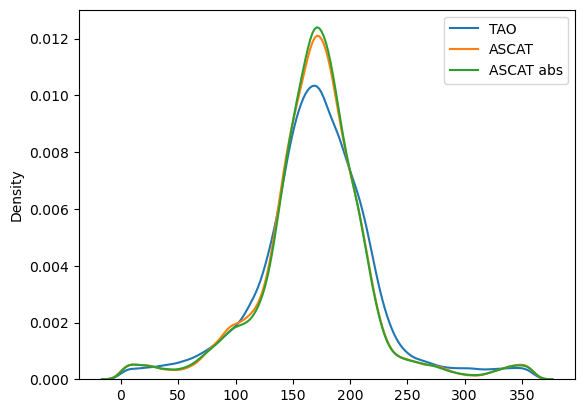

In [43]:
sns.kdeplot(df['WDIR (TAO)'], label = 'TAO',)
sns.kdeplot(df['WDIR (ASCAT)'], label = 'ASCAT')
sns.kdeplot(df['WDIR (ASCAT) absolute'], label = 'ASCAT abs')
plt.legend()

In [44]:
df.to_netcdf(f'rainFlagRemovedBuoyDataBadQualityRemovedMatchup_{metop}_waveAndGlorysAdded.nc')

In [45]:
dsA = xr.open_dataset(f'rainFlagRemovedBuoyDataBadQualityRemovedMatchup_MetOP_A_waveAndGlorysAdded.nc')
dsB = xr.open_dataset(f'rainFlagRemovedBuoyDataBadQualityRemovedMatchup_MetOP_B_waveAndGlorysAdded.nc')
dsB['count'] = dsB['count'] + np.max(dsA['count'].to_numpy()) + 1

ds = xr.concat([dsA, dsB], dim='count')
ds.to_netcdf(f'rainFlagRemovedBuoyDataBadQualityRemovedMatchup_MetOP_AB_waveAndGlorysAdded.nc')